改編自kaggle這篇,sst-2
https://www.kaggle.com/jgggjkmf/roberta-sst-2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
pip install -q transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 16.8MB/s 
     |████████████████████████████████| 890kB 34.3MB/s 
     |████████████████████████████████| 1.1MB 41.3MB/s 


In [4]:
import shutil
shutil.copytree("/content/drive/My Drive/DL/情感分析", r"/content/sst")

'/content/sst'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv(r"/content/sst/train.csv",encoding='utf-8')
from sklearn.utils import shuffle
df = shuffle(df)

print(df.shape)
df_test = pd.read_csv(r'/content/sst/test.csv')
# df_test['rating']= "10"
print(df_test.head())

(146811, 3)
   review_id                                             review
0          1  Great danger, cool, motif and cantik2 jg model...
1          2                   One of the shades don't fit well
2          3                                   Very comfortable
3          4  Fast delivery. Product expiry is on Dec 2022. ...
4          5  it's sooooo cute! i like playing with the glit...


In [6]:
from sklearn.model_selection import train_test_split
train = df.iloc[0:120000,]
val = df.iloc[120001:,]
# test = df.iloc[120001:,]

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [36]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 3.0.2


In [37]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [38]:
# Parameters
seed = 42
use_fp16 = False
bs = 12

model_type = 'roberta'
pretrained_model_name = 'roberta-large'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [39]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [40]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [41]:
seed_all(seed)

In [42]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [43]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [44]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [45]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [46]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [47]:
databunch = (TextList.from_df(train, cols='review', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'rating')
             .add_test(df_test['review'])
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

AttributeError: ignored

In [ ]:
valid_databunch = (TextList.from_df(val, cols='review', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'rating')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [48]:
import torch.tensor as Tensor
def dropout_mask(x:Tensor, sz, p:float):
    "Return a dropout mask of the same type as x, size sz, with probability p to cancel an element."
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class RNNDropout(nn.Module):
    "Dropout with probability p that is consistent on the seq_len dimension."

    def __init__(self, p:float=0.5): 
        super(RNNDropout, self).__init__()
        self.p=p

    def forward(self, x:Tensor)->Tensor:
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

class WeightDropout(nn.Module):
    "A module that warps another layer in which some weights will be replaced by 0 during training."

    def __init__(self, module:nn.Module, weight_p:float, layer_names=['weight_hh_l0']):
        super(WeightDropout, self).__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            # Registered in list of parameters
            self.register_parameter(str(layer)+'_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        "Apply dropout to the raw weights."
        for layer in self.layer_names:
            raw_w = getattr(self, str(layer) +'_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

    def reset(self):
        for layer in self.layer_names:
            raw_w = getattr(self, str(layer) + '_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
        if hasattr(self.module, 'reset'): self.module.reset()

In [49]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        self.transformer = self.transformer
        self.rnns = [nn.LSTM(1024 if l == 0 else 1152,
                            (1152 if l != 2-1 else 1024)//2,
                            1, bidirectional = True, batch_first = True) for l in range(2)]
        
        
        self.rnns = [WeightDropout(rnn, 0.4) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.hidden_dps = nn.ModuleList([RNNDropout(0.5) for l in range(2)])
        self.out = nn.Linear(1024,5)
        self.bs = bs
        
    def forward(self, input_ids, attention_mask=None):
        self.bs =input_ids.shape[0]
        self.reset()
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in `[0, 1]`:
        # `1` for tokens that are NOT MASKED, `0` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        raw_output = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]
#         print(raw_output.shape)
# #         hidden, _ = self.rnns(logits)
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns,self.hidden_dps)):
            raw_output,_ = rnn(raw_output, self.hidden[l])
            if l != 2-1:raw_output = hid_dp(raw_output)
        output = self.out(raw_output)
        return output.mean(1).squeeze()
    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (1152 if l != 1 else 1024) //2
        return torch.zeros(2,self.bs,nh).cuda()
    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(2)]

In [50]:
#參考https://huggingface.co/roberta-large
from transformers import RobertaTokenizer, RobertaModel
transformer_model = RobertaModel.from_pretrained("roberta-large")
# transformer_model = RobertaModel.from_pretrained("roberta-base")

In [51]:
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)
custom_transformer_model

CustomTransformerModel(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): Lay

In [52]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
# if use_fp16: learner = learner.to_fp16()

In [53]:
learner.data.valid_dl = valid_databunch.train_dl

In [54]:
# For roberta-base
list_layers = [learner.model.transformer.embeddings,
              learner.model.transformer.encoder.layer[0],
              learner.model.transformer.encoder.layer[1],
              learner.model.transformer.encoder.layer[2],
              learner.model.transformer.encoder.layer[3],
              learner.model.transformer.encoder.layer[4],
              learner.model.transformer.encoder.layer[5],
              learner.model.transformer.encoder.layer[6],
              learner.model.transformer.encoder.layer[7],
              learner.model.transformer.encoder.layer[8],
              learner.model.transformer.encoder.layer[9],
              learner.model.transformer.encoder.layer[10],
              learner.model.transformer.encoder.layer[11],
              learner.model.transformer.encoder.layer[12],
              learner.model.transformer.encoder.layer[13],
              learner.model.transformer.encoder.layer[14],
              learner.model.transformer.encoder.layer[15],
              learner.model.transformer.encoder.layer[16],
              learner.model.transformer.encoder.layer[17],
              learner.model.transformer.encoder.layer[18],
              learner.model.transformer.encoder.layer[19],
              learner.model.transformer.encoder.layer[20],
              learner.model.transformer.encoder.layer[21],
              learner.model.transformer.encoder.layer[22],
              learner.model.transformer.encoder.layer[23],
              learner.model.transformer.pooler,
              learner.model.rnns]

In [55]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 27 groups
[Sequential(
  (0): Embedding(50265, 1024, padding_idx=1)
  (1): Embedding(514, 1024, padding_idx=1)
  (2): Embedding(1, 1024)
  (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=1024, out_features=4096, bias=True)
  (8): Linear(in_features=4096, out_features=1024, bias=True)
  (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=10

In [56]:
learner.save('untrain')
seed_all(seed)
learner.load('untrain');

Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f7bb1602940>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [57]:
learner.model.reset()
learner.freeze_to(-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.91E-05


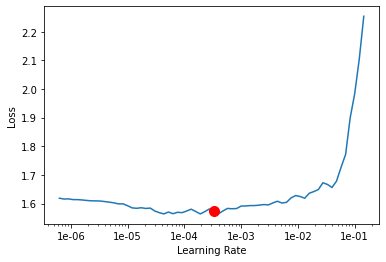

In [58]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.020883,1.034950,0.488660,0.511340,15:18


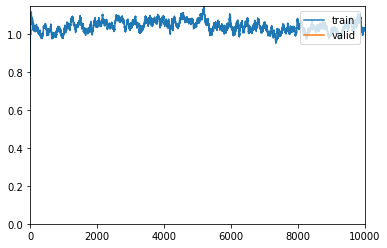

In [60]:
learner.fit_one_cycle(1,max_lr=3.63E-05,moms=(0.8,0.7))

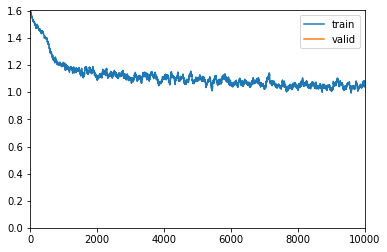

[1.0409502, tensor(0.4884), tensor(0.5116)]

In [149]:
learner.validate(valid_databunch.train_dl)

In [29]:
# learner.model.reset()
# learner.freeze_to(-5)
# lr = 1e-4
# learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: ignored

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 9.12E-06


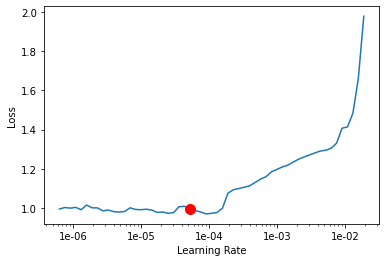

In [112]:
# learner.model.reset()
# learner.freeze_to(-5)
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.005282,1.039956,0.491271,0.508729,18:16
1,1.024453,1.040048,0.490376,0.509624,18:17
2,0.978562,1.044818,0.486310,0.513690,18:27
3,1.007766,1.082092,0.481237,0.518763,18:41
4,0.998239,1.058046,0.478850,0.521150,18:35
5,0.938346,1.110907,0.481796,0.518203,18:37
6,0.924431,1.110848,0.482132,0.517868,18:38
7,0.894474,1.123253,0.480454,0.519546,18:39
8,0.863359,1.146830,0.477917,0.522083,18:43
9,0.764657,1.221904,0.480789,0.519211,18:39


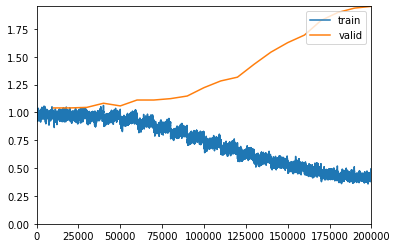

In [113]:
# learner.model.reset()
learner.model.transformer.train()
learner.freeze_to(-8)
lr = 5.25E-05
learner.fit_one_cycle(20, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

預測
他會打亂排序,詳見官方文件:https://docs.fast.ai/text.learner.html


In [115]:
learner.model.transformer.eval()
preds = learner.get_preds(DatasetType.Test)[0].detach().cpu().numpy()

In [116]:
sampler = [i for i in databunch.dl(DatasetType.Test).sampler]

In [117]:
reverse_sampler = np.argsort(sampler)
ordered_preds = preds[reverse_sampler, :]
pred_values = np.argmax(ordered_preds, axis=1)

In [118]:
labels = pred_values+1

In [119]:
答案 = df_test
答案["rating"] = labels

In [120]:
答案.iloc[60228:60278,]

,review_id,review,rating
60228,60229,Its products all would be okay and the price i...,3
60229,60230,Like the picture in the ad. Send the correct e...,5
60230,60231,"terdabesttt .. first x try, hopefully it fits ...",4
60231,60232,was a present and we did it fit as expected an...,3
60232,60233,Got it yesterday! I brought white and black . ...,5
60233,60234,Good fit and very comfortable .,4
60234,60235,Great pair of shoes for just about any activity,4
60235,60236,Comfortablelite weight fit well .,3
60236,60237,I have really flat and wide feet .,5
60237,60238,These are tight around the toes and likely wil...,1


In [121]:
一星 = 答案[答案["rating"]== 1].count()[0]
二星 =答案[答案["rating"]== 2].count()[0]
三星 =答案[答案["rating"]== 3].count()[0]
四星 =答案[答案["rating"]== 4].count()[0]
五星 =答案[答案["rating"]== 5].count()[0]

In [122]:
print(一星,二星,三星,四星,五星)

4523 3515 11177 20498 20714


In [123]:
final答案 = 答案.drop(columns=["review"])


In [108]:
# 答案.to_csv("/content/drive/My Drive/DL/情感分析/final答案_4epoch.csv",index=False)

In [124]:
final答案.to_csv("/content/drive/My Drive/DL/情感分析/final答案_epoch_a10.csv",index=False)